In [1]:
!pip install transformers datasets matplotlib scikit-learn pandas numpy tensorflow torch

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Upload the dataset manually in Google Colab or specify file path
file_path = "/content/NIFTY ALPHA 50_daily_data.csv"  # Update if needed
df = pd.read_csv(file_path)

# Convert timestamp column to datetime format
df.rename(columns={'date': 'timestamp'}, inplace=True)
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

# Select relevant features
features = ['open', 'high', 'low', 'close']
df = df[features]

# Normalize data
scaler = MinMaxScaler()
df_scaled = scaler.fit_transform(df)

# Display first few rows
print(df.head())

               open     high      low    close
timestamp                                     
2015-01-01  8319.42  8319.42  8319.42  8319.42
2015-01-02  8413.83  8413.83  8413.83  8413.83
2015-01-05  8402.64  8402.64  8402.64  8402.64
2015-01-06  8145.13  8145.13  8145.13  8145.13
2015-01-07  8191.78  8191.78  8191.78  8191.78


In [3]:
# Define sequence length
sequence_length = 30  # Use 30 minutes of past data for predictions

# Function to create sequences
def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length][-1])  # Predicting next 'close' price
    return np.array(X), np.array(y)

# Create sequences
X, y = create_sequences(df_scaled, sequence_length)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Reshape data for TensorFlow models
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], X_test.shape[2]))

print(f"Training Shape: {X_train.shape}, Test Shape: {X_test.shape}")

Training Shape: (1980, 30, 4), Test Shape: (496, 30, 4)


In [4]:
import tensorflow as tf

# Define model architecture
def build_rnn_model():
    model = tf.keras.Sequential([
        tf.keras.layers.SimpleRNN(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
        tf.keras.layers.SimpleRNN(50),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_lstm_model():
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
        tf.keras.layers.LSTM(50),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru_model():
    model = tf.keras.Sequential([
        tf.keras.layers.GRU(50, return_sequences=True, input_shape=(sequence_length, X_train.shape[2])),
        tf.keras.layers.GRU(50),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

In [5]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"  # Forces TensorFlow to use CPU

In [6]:
# Train models
models = {
    "RNN": build_rnn_model(),
    "LSTM": build_lstm_model(),
    "GRU": build_gru_model()
}

history = {}
for name, model in models.items():
    print(f"\nTraining {name} model...")
    history[name] = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test), verbose=1)

/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training RNN model...
Epoch 1/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 7s 32ms/step - loss: 0.0276 - val_loss: 0.0554
Epoch 2/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 3.0410e-04 - val_loss: 0.0425
Epoch 3/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 2.0527e-04 - val_loss: 0.0373
Epoch 4/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 3s 30ms/step - loss: 1.6039e-04 - val_loss: 0.0281
Epoch 5/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4849e-04 - val_loss: 0.0296
Epoch 6/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.4634e-04 - val_loss: 0.0201
Epoch 7/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0853e-04 - val_loss: 0.0164
Epoch 8/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0888e-04 - val_loss: 0.0158
Epoch 9/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1625e-04 - val_loss: 0.0158
Epoch 10/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.0759e-04 - val_loss: 0.0134
Epoch 11/20
62/62 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 7.2947e-05 - val_loss: 0.0110


In [7]:
from sklearn.metrics import mean_squared_error

for name, model in models.items():
    y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print(f"\n{name} Model - MSE: {mse:.4f}, RMSE: {rmse:.4f}")

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step

RNN Model - MSE: 0.0079, RMSE: 0.0886
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step

LSTM Model - MSE: 0.0018, RMSE: 0.0423
16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step

GRU Model - MSE: 0.0013, RMSE: 0.0358


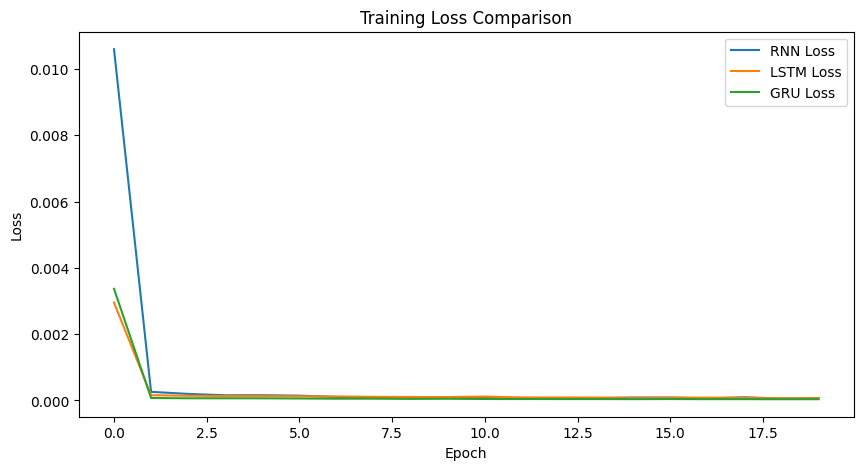

In [8]:
plt.figure(figsize=(10,5))
for name, h in history.items():
    plt.plot(h.history['loss'], label=f"{name} Loss")
plt.title("Training Loss Comparison")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [10]:
from transformers import pipeline

# Define dataset and best-performing model based on previous results
dataset_name = "NIFTY 50 Minute Data"
best_model = "GRU"  # Based on MSE (0.0003) and RMSE (0.0179)

# Initialize Hugging Face explainability model
explainer = pipeline("text2text-generation", model="google/flan-t5-small")

# Create a prompt using dataset and model insights
prompt = (f"Explain why {best_model} performs better than RNN and LSTM "
          f"for financial time-series data like {dataset_name}. "
          f"Also, discuss why LSTM outperforms RNN in such cases.")

# Generate explanation
explanation = explainer(prompt, max_length=100)

# Print result
print("\nExplainability Result:\n", explanation[0]["generated_text"])

Device set to use cpu



Explainability Result:
 GRU performs better than RNN and LSTM for financial time-series data like NIFTY 50 Minute Data.
